In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Models to be used
from model.model_init import PITGAN
from data_processing.data_transformer import DataTransformer

# Data loading functions
from data_processing.basic_synthetic_dataset import generate_basic_2D

# Plot functions
from visualizations.scatter_plots import plot_2D_data, plot_priv_utility
from visualizations.training_loss_plots import plot_losses

# Evaluation functinos
from evaluation.evaluation_procedure import evaluate_full, evaluate
from evaluation.utility import compute_ROC, compute_CIO, compute_CIO_folds, compute_pMSE

# Additional functions
from model.model_helpers import get_latent_dims

This file contains the full streamlined evaluation procedure for any data. 

It follows the following steps
1. It starts by loading in the data
2. Then it fits a transformer to this data which is adequate
3. Then full evaluation procedure is run over various latent dimensions
4. Then these evaluation outputs are used to plot the privacy-utility graph
5. Finally some of these optimal paramters from the evaluation are used to gain further insight into the model performance

## 1) Load Data
First the data is loaded in the data from whatever source. In this example the basic synthetic data example is used.

Another option is load in a subset of ACS census data

In [5]:
# Load the census data
X_train = pd.read_csv('C:/Users/olsda/OneDrive/Documents/NU classes/Year 4/MMSS Thesis/PITGAN Implenetation/Data/usa_00001/census_clean_2019.csv', index_col=False)

# Sample only a certain portion
X_train = X_train.sample(n=10000)

X_train.head()

,REGION,SEX,MARST,RACE,CITIZEN,EDUC,HEALTHCOV,EMPSTAT,POVERTY,INCTOT,FAMSIZE,AGE
811132,Midwest,Female,Separated,Multi,Yes,High_School,Pub_Cov,Not_in_LaborF,Below,780,1,61
2265911,West,Female,Separated,White,Yes,High_School,Pub_Cov,Not_in_LaborF,Below,24000,1,64
81939,West,Female,Married,White,Yes,High_School,Priv_Cov,Employed,Above,62200,3,54
1715948,Midwest,Female,Single,White,Yes,High_School,Priv_Cov,Not_in_LaborF,Above,3500,3,22
585979,South,Female,Married,Asian,Yes,Masters,Priv_Cov,Employed,Above,486000,3,56


## 2) Fit Transformer

This section fits the data transformer to the distribution. This is an important step of the process as the restructured representation can greatly impact the performace of the model. 

It is suggested to pick a representation which contains as few modes, or the most relevant modes, for the continuous variables as possible. This will both reduce the dimensionality of the feature space the generative model is trained on, as well as avoid unnecessarily complicated latice spaces that may either be difficult for the autoencoder to learn, or make the encoded space less useful later on.

In [6]:
# Initialize the transformer
transformer = DataTransformer()

# Specify which columns are discrete, important for both the transformer and functions later on
discrete_columns = ['REGION','SEX','MARST','RACE','CITIZEN','EDUC','HEALTHCOV','EMPSTAT','POVERTY']

# Train the transformer
transformer.fit(X_train, discrete_columns)

# Get the dimensionality of the modes, repeat fitting until a sufficiently low numer of modes are found
D_list, C_list = transformer.get_relevant_dimensions()

C_list

[7, 8, 10]

## 3) Run Evaluation

This is the longest step, both to set up and to run. It consists of two steps, first setting up all of the parameters needed for the full evaluation procedure, then running the actual procedure.

The first part is crucial for successful training. While grid search is employed in the evaluation procedure it, since this procedure is run for a number of different latent dimensions, the training time compounds the more parameters are added. It is recommended to run a handful of smaller scale tests to hone in on which parameter ranges would likely be the most appropriate. The individual parameter choices are explained in more detail below.

The actual evaluation portion this is the part that will take the longest to run, so it is recommended to run on GPU supported processing for accelerated network training.

First take a look at the different options for the latent dimensions. The function latent_dims takes as input the total number of categories over all categorical variables, as well as the total number of modes across all continuous variables, and then outputs a table with the latent dimension size, the states on the lattice covered by this dimeniosn, and the number of states remaining.

This function gives you an overall sense of how effective the different latent dimensions sizes may be, as well as the higher dimension size before identity mapping becomes possible. It is recommended to only run the evaluation on only the dimension lister here, or potentially less depending on prior knowledge.

In [7]:
# Run latent_dims
get_latent_dims(D_list, C_list)

+--------------+------------------+--------------------+
|   Latent Dim |   States Covered |   States Remaining |
+==============+==================+====================+
|            0 |                0 |           15482880 |
+--------------+------------------+--------------------+
|            1 |                2 |           15482878 |
+--------------+------------------+--------------------+
|            2 |                4 |           15482874 |
+--------------+------------------+--------------------+
|            3 |                8 |           15482866 |
+--------------+------------------+--------------------+
|            4 |               16 |           15482850 |
+--------------+------------------+--------------------+
|            5 |               32 |           15482818 |
+--------------+------------------+--------------------+
|            6 |               64 |           15482754 |
+--------------+------------------+--------------------+
|            7 |              1

In [8]:
# Select the dimensions for evaluation
latent_dims = [0,5,10,15,20]

The next portion specifies the size or complexity of the network, broken down into the size of the different network parts. 

In [14]:
# Initialize the dictionary for the model sizes
hidden_dimensions = {
    'dim_e': [256, 128, 64],
    'dim_r': [64, 128, 256],
    'dim_g': [512, 512, 512],
    'dim_c': [512, 512, 512],
}

The next portion specifies the overall parameters to be used

In [15]:
# Initialize the dictionary for the overall model parameters
parameters = {
    'alpha_sup': 5, # balances sup and unsup loss for generator 
    'alpha_grad': 3, # balances gradient pen in critic loss
    'batch_size': 512,
    'grad_step_critic': 0.001,
    'grad_step_generator': 0.001,
    'grad_step_autoencoding': 0.001,
    'sigmoid_temp': 0.3,
    'softmax_temp': 0.3,
    'critic_steps': 5,
    'scale_continuous': 2,
    'scale_noise': 1,
    'scale_discrete': 2,
    'R': 20
}

### Intermediate testing step

In [16]:
model = PITGAN(5, hidden_dimensions, parameters, transformer)

In [ ]:
losses_auto = model.fit_autoencoder(X_train, 10)

In [17]:
losses_gen = model.fit_generative(X_train, 15)

---Starting Generative Training


InvalidArgumentError: Exception encountered when calling Concatenate.call().

[1m{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [512,20] vs. shape[1] = [272,5] [Op:ConcatV2] name: concat[0m

Arguments received by Concatenate.call():
  • inputs=['tf.Tensor(shape=(512, 20), dtype=float32)', 'tf.Tensor(shape=(272, 5), dtype=float32)']

In [ ]:
plot_losses(losses_gen, False)

Evaluation

In [ ]:
# Specify the sets of keys to be used for privacy evaluation
key_sets = [['REGION','SEX'],['REGION','SEX','MARST','RACE']]

# Specify the regressions to be sued for CIO evaluation
regressions = {
    'Income_Full': (['INCTOT'],['AGE','FAMSIZE'],['SEX','RACE','CITIZEN','EDUC'])
}

# Specify utility weights
utility_weights = [0.33, 0.33, 0.33]

In [ ]:
results = evaluate(X_train, model, transformer, discrete_columns, key_sets, regressions)

### Continue Full Evaluation

The next portion specifies the training specific hyper parameters to be used in the grid search.

In [11]:
# Initialize the dict for the autoencoder hyperparameters
hyper_params_sup = [0.001, 0.0005, 0.0001]

# Initialize the dictionary for the generative model grid
hyper_params_unsup = {
    'grad_step_critic': [0.001, 0.0001],
    'grad_step_generator': [0.001, 0.0001]
}

In [12]:
# Initialize the dict for the autoencoder hyperparameters
hyper_params_sup = [0.001, 0.0001]

# Initialize the dictionary for the generative model grid
hyper_params_unsup = {
    'grad_step_critic': [0.001],
    'grad_step_generator': [0.0001]
}

The next portion specifies the number of ephods for the autoencoder and unsupervised trianing

In [13]:
# Specify autoencoder epochs
auto_epochs = 100

# Specify unsupervised epochs
gen_epochs = 350

In [14]:
# Specify autoencoder epochs
auto_epochs = 100

# Specify unsupervised epochs
gen_epochs = 50

Next section specifies the evaluation parameters

In [15]:
# Specify the sets of keys to be used for privacy evaluation
key_sets = [['Category']]

# Specify the regressions to be sued for CIO evaluation
regressions = {
    'Dim_1': (['Dimension_1'],['Dimension_2'],['Category']),
    'Dim_2': (['Dimension_2'],['Dimension_1'],['Category'])
}

# Specify utility weights
utility_weights = [0.33, 0.33, 0.33]

Finally run the actual evaluation procedure.

In [16]:
# Run the evaluation
evaluation_results, global_hyper_params = evaluate_full(
    X_train, transformer, discrete_columns, latent_dims, hidden_dimensions, 
    parameters, hyper_params_sup, hyper_params_unsup, auto_epochs, gen_epochs,
    key_sets, regressions, utility_weights
)


---Starting Autoencoder Training
Epoch 0: Reconstruction Loss = 1.4386321306228638
Epoch 1: Reconstruction Loss = 1.4371367692947388
Epoch 2: Reconstruction Loss = 1.4355782270431519
Epoch 3: Reconstruction Loss = 1.4340529441833496
Epoch 4: Reconstruction Loss = 1.4325519800186157
Epoch 5: Reconstruction Loss = 1.4310582876205444
Epoch 6: Reconstruction Loss = 1.4295669794082642
Epoch 7: Reconstruction Loss = 1.428078532218933
Epoch 8: Reconstruction Loss = 1.4265891313552856
Epoch 9: Reconstruction Loss = 1.4251489639282227
Epoch 10: Reconstruction Loss = 1.423697829246521
Epoch 11: Reconstruction Loss = 1.4222310781478882
Epoch 12: Reconstruction Loss = 1.4208110570907593
Epoch 13: Reconstruction Loss = 1.4193897247314453
Epoch 14: Reconstruction Loss = 1.41799795627594
Epoch 15: Reconstruction Loss = 1.4165658950805664
Epoch 16: Reconstruction Loss = 1.415201187133789
Epoch 17: Reconstruction Loss = 1.4138065576553345
Epoch 18: Reconstruction Loss = 1.4124394655227661
Epoch 19: Re

In [17]:
evaluation_results

,Latent_dim,Decoded_ROC,ROC,CIO,pMSE,PMSE4,1-keys
0,0,NaN,0.341766,0.141999,0.117937,0.528250,0.000000
1,1,0.658826,0.331870,0.000000,0.124532,0.501874,0.993289
2,2,0.600167,0.571868,0.000000,0.200512,0.197953,0.000000
3,3,0.936614,0.863330,0.004997,0.157672,0.369312,0.993918


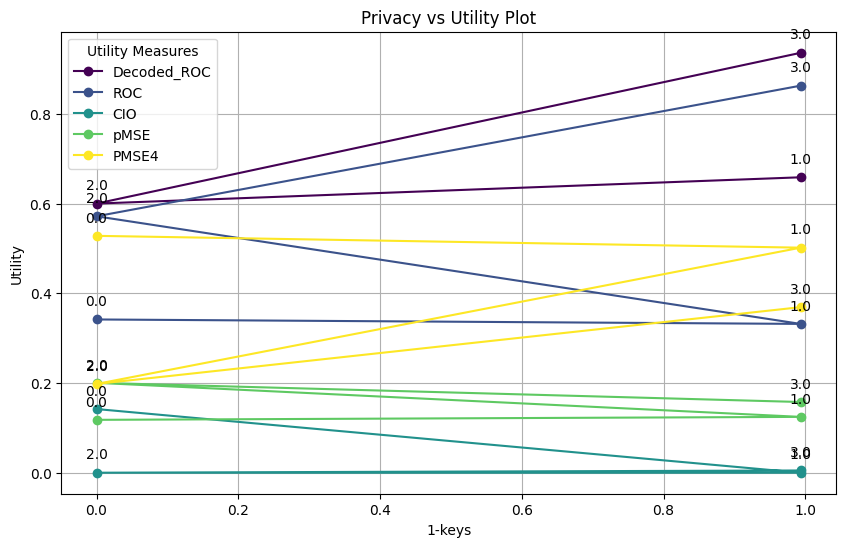

In [18]:
# Plot the lines
plot_priv_utility(evaluation_results, False, '1-keys')